In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### head

In [6]:
ACT = "sigmoid"
AUX_PARAM = None

### Optimizer Settings

In [7]:
OPTIM_NAME = "adam"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [8]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [9]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    loss_x = 0
    loss_y = 0
    for index, data in tqdm(enumerate(dataloader)):
        
        x, y, *_ = data

        x = x.to(device)
        y = y.to(device)

        x_cls = model(x)
        x_cls = Activation(name=ACT)(x_cls) # zipped value to [0, 1]
        x_loss = nn.BCELoss()(x_cls.float(), torch.zeros(x_cls.size(), dtype=torch.float, device=device))
        
        y_cls = model(y)
        y_cls = Activation(name=ACT)(y_cls) # zipped value to [0, 1]
        y_loss = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device))
        
        _loss = x_loss + y_loss
                        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        loss_x += x_loss.item()
        loss_y += y_loss.item()

    return x_loss/(index+1), y_loss/(index+1) 

In [10]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    acc_x = []
    acc_y = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, *_ = data

        x = x.to(device)
        y = y.to(device)

        x_cls = model(x)
        x_cls = Activation(name=ACT)(x_cls) # zipped value to [0, 1]
        x_acc = Accuracy()(x_cls, torch.zeros(x_cls.size(), device=x_cls.device))
        
        y_cls = model(y)
        y_cls = Activation(name=ACT)(y_cls) # zipped value to [0, 1]
        y_acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        
        acc_x += [x_acc.item()]
        acc_y += [y_acc.item()]

    return sum(acc_x)/len(acc_x), sum(acc_x)/len(acc_x)

In [11]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    acc_x = []
    acc_y = []
    thresh = 0.5
    for index, data in tqdm(enumerate(dataloader)):

        x, y, *_ = data

        x = x.to(device)
        y = y.to(device)

        x_cls = model(x)
        x_cls = Activation(name=ACT)(x_cls).squeeze() # zipped value to [0, 1]
        y_cls = model(y)
        y_cls = Activation(name=ACT)(y_cls).squeeze() # zipped value to [0, 1]

        for b in x.size()[0]:
            _x = "CT" if x_cls[b] > thresh else "CBCT"
            _y = "CT" if y_cls[b] > thresh else "CBCT"
            print("Groundtruth: {}, Prediction: {}".format("CBCT", _x))
            print("Groundtruth: {}, Prediction: {}".format("CT", _y))


# Read Data

In [12]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [13]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [14]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [15]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f31c0b542b0>,)

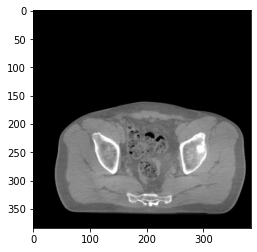

In [18]:
plt.imshow(x.squeeze(), 'gray'),

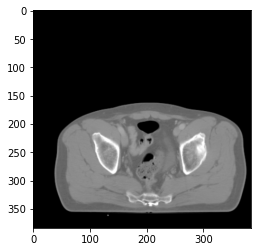

In [19]:
plt.imshow(y.squeeze(), 'gray')

In [20]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# Model

In [21]:
from codes.activation import Activation

In [22]:
class Model(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveMaxPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# training

In [23]:
import wandb

wandb.init(project="discriminator", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [25]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)

model = Model(encoder=model.encoder, hidden_ch=2048, n_classes=N_CLASSES, activation=ACT)

In [26]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [27]:
wandb.watch(model)

max_acc = 0

for epoch in range(EPOCH):
        
        loss_cbct, loss_ct = train_epoch(model, optimizer, trainloader, device)
        cbct_acc_train, ct_acc_train = eval_epoch(model, trainloader, device)
        cbct_acc_test, ct_acc_test = eval_epoch(model, testloader, device)

        
        wandb.log({
            "cbct bce loss": loss_cbct,
            "ct bce loss": loss_ct,
            "trainset cbct acc": cbct_acc_train,
            "trainset ct acc": ct_acc_train,
            "testset cbct acc": cbct_acc_test,
            "testset ct acc": ct_acc_test
        })
        
        
        if max_acc < cbct_acc_test + ct_acc_test:
            max_acc = cbct_acc_test + ct_acc_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("discriminator", "{}.pth".format(wandb.run.name)))

84it [02:12,  1.58s/it]
84it [00:41,  2.00it/s]
12it [00:06,  1.78it/s]
84it [02:06,  1.51s/it]
84it [00:41,  2.01it/s]
12it [00:06,  1.77it/s]
84it [02:09,  1.54s/it]
84it [00:42,  2.00it/s]
12it [00:06,  1.78it/s]
84it [02:07,  1.52s/it]
84it [00:40,  2.06it/s]
12it [00:07,  1.60it/s]
84it [02:12,  1.58s/it]
84it [00:38,  2.17it/s]
12it [00:09,  1.33it/s]
84it [02:14,  1.60s/it]
84it [00:37,  2.24it/s]
12it [00:08,  1.47it/s]
84it [02:10,  1.56s/it]
84it [00:39,  2.13it/s]
12it [00:07,  1.62it/s]
84it [02:12,  1.58s/it]
84it [00:41,  2.04it/s]
12it [00:07,  1.62it/s]
84it [02:13,  1.59s/it]
84it [00:37,  2.25it/s]
12it [00:06,  1.77it/s]
84it [02:10,  1.55s/it]
84it [00:38,  2.21it/s]
12it [00:06,  1.76it/s]
84it [02:12,  1.57s/it]
84it [00:36,  2.28it/s]
12it [00:06,  1.78it/s]
84it [02:12,  1.57s/it]
84it [00:41,  2.00it/s]
12it [00:06,  1.77it/s]
84it [02:05,  1.50s/it]
84it [00:42,  2.00it/s]
12it [00:06,  1.76it/s]
84it [02:09,  1.54s/it]
84it [00:42,  2.00it/s]
12it [00:06,  1.

In [29]:
# cbct_acc_test, ct_acc_test
eval_epoch(model, testloader, device)

12it [00:03,  3.33it/s]


(1.0, 1.0)